# Ensemble Methods and Skewed Data

For this project I am going to use two ensemble methods:

  - AdaBoost
  - Random Forests
  
Along with applying different KPIs (key performance indicators) that are more appropriate to highly skewed data sets. 

The dataset contains transactions made by credit cards in September 2013 by european cardholders.
This dataset presents transactions that occurred in two days, where we have 237 frauds out of 142,167 transactions. The dataset is highly unbalanced, the positive class (frauds) account for 0.17% of all transactions.

It contains only numerical input variables which are the result of a [PCA transformation](https://en.wikipedia.org/wiki/Principal_component_analysis). Unfortunately, due to confidentiality issues, I cannot provide the original features and more background information about the data. Features V1, V2, … V28 are the principal components obtained with PCA, the only features which have not been transformed with PCA are 'Time' and 'Amount'. Feature 'Time' contains the seconds elapsed between each transaction and the first transaction in the dataset. The feature 'Amount' is the transaction Amount in Euros. Feature 'Class' is the response variable and it takes value 1 in case of fraud and 0 otherwise.
 

In [1]:
# These are the libraries I will use for this project
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
%matplotlib inline
from sklearn.ensemble import AdaBoostClassifier
from sklearn.ensemble import RandomForestClassifier
from sklearn.model_selection import StratifiedKFold
from sklearn.metrics import plot_roc_curve

# This is the credit card data I used. I'll use sklearn methods to do cross validation
# to estimate error
df_cc = pd.read_csv('cc.csv')

## Parition the data for cross validation

I will load the data, and split the data set into $X$ (the feature dataframe, `df_X`) and $y$ (the target series `s_y`). 

 I will use $k=3$ and instantiate an instance of the `StratifiedKFold` class, and use the generator `split` to populate the test and train dictonaries:
   - `d_train_df_X` : key is the fold number, value is the attribute training dataframe at that fold
   - `d_test_df_X`  : key is the fold number, value is the attribute test dataframe at that fold
   - `d_train_s_y`  : key is the fold number, value is the target training series at that fold
   - `d_train_s_y`  : key is the fold number, value is the target test series at that fold

In [2]:
df_X = df_cc.drop(columns=['Class'])
s_y = df_cc['Class']

In [3]:
skf = StratifiedKFold(n_splits=3,shuffle=True,random_state=23)

In [4]:
d_train_df_X = dict()
d_test_df_X = dict()
d_train_s_y = dict()
d_test_s_y = dict()

k = 1

for train_index,test_index in skf.split(df_X,s_y):
    d_train_df_X[k] = df_X.iloc[train_index]
    d_test_df_X[k] = df_X.iloc[test_index]
    d_train_s_y[k] = s_y.iloc[train_index]
    d_test_s_y[k] = s_y.iloc[test_index]
    k+=1

In [5]:
# Verifying that the target training is equally distributed as possible
for key in d_test_s_y.keys():
    print(d_test_s_y[key].value_counts())


0    47389
1       79
Name: Class, dtype: int64
0    47389
1       79
Name: Class, dtype: int64
0    47389
1       79
Name: Class, dtype: int64


## Section 1 - AdaBoost

## Test the Performance of AdaBoost

In this assignment, I will use the implementation of [AdaBoost in Scikit-learn](https://scikit-learn.org/stable/modules/generated/sklearn.ensemble.AdaBoostClassifier.html). 

After I fit an AdaBoost model, I will call the method `predict` to get a class prediction. These probabilities are used when creating ROC curves. 

I will loop over the $k$ folds using the dictionaries from the first problem, and for each fold calculate the accuracy, TPR, the PPV, and the FPR.  I will plot the ROC curve for each fold. 

When creating your AdaBoost classifier, I will use the following parameters: 
`AdaBoostClassifier(n_estimators=25, random_state=23)`

I will save the predictions from the 3rd fold into a variable called `y_hat_ab` for use in a future section.


In [6]:
k = 3
acc_ab = np.zeros(k)
tpr_ab = np.zeros(k)
ppv_ab = np.zeros(k)
fpr_ab = np.zeros(k)

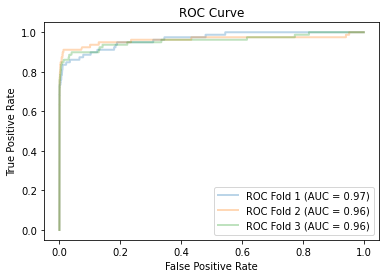

In [7]:
clf = AdaBoostClassifier(n_estimators=25, random_state=23)
n = 0
fig, ax = plt.subplots()
for i in range(1,k+1):
    
    clf.fit(d_train_df_X[i],d_train_s_y[i])
    exp = clf.predict(d_test_df_X[i])
    
    if i == 3:
        y_hat_ab = exp
    
        
    true_idx = d_test_s_y[i] == 1
    false_idx = d_test_s_y[i] == 0
    p_true_idx = exp == 1
    
    P = true_idx.sum()
    N = false_idx.sum()
    TP_p_FP = p_true_idx.sum()
    
    TP = ( exp[true_idx] == d_test_s_y[i][true_idx] ).sum()
    FP = TP_p_FP - TP
    TN = N - FP
    
    np.put(acc_ab,[n],(TP+TN)/len(exp))
    np.put(fpr_ab,[n],FP/N)
    np.put(ppv_ab,[n],TP/TP_p_FP)
    np.put(tpr_ab,[n],TP/P)
    
    n+=1
    
    plot_roc_curve(clf,d_test_df_X[i], d_test_s_y[i], name = 'ROC Fold {}'.format(i),alpha = 0.3, lw=2, ax=ax)
    plt.ylabel('True Positive Rate')
    plt.xlabel('False Positive Rate')
    plt.title('ROC Curve')
plt.show()
    
    

In [8]:
print('The min, mean, and max TPR are: {:.2f}, {:.2f}, and {:.2f}'.format(tpr_ab.min(), tpr_ab.mean(), tpr_ab.max()))
print('The min, mean, and max PPV are: {:.2f}, {:.2f}, and {:.2f}'.format(ppv_ab.min(), ppv_ab.mean(), ppv_ab.max()))
print('The min, mean, and max ACC are: {:.2f}, {:.2f}, and {:.2f}'.format(acc_ab.min(), acc_ab.mean(), acc_ab.max()))

The min, mean, and max TPR are: 0.62, 0.65, and 0.71
The min, mean, and max PPV are: 0.75, 0.79, and 0.82
The min, mean, and max ACC are: 1.00, 1.00, and 1.00


## Test the Performance of Random Forests

Now, I'll try another ensemble method: Random Forests, again using the [Scikit-learn implementation](https://scikit-learn.org/stable/modules/generated/sklearn.ensemble.RandomForestClassifier.html). 

After I fit an RandomForest model, I can call the method `predict` to get a class prediction. These probabilities are used when creating ROC curves. 

I will loop over the $k$ folds using the dictionaries from the first problem, and for each fold calculate the accuracy, TPR, the PPV, and the FPR.  I will plot the ROC curve for each fold. 

When creating my Random Forest classifier, I will use the following parameters: 
`RandomForestClassifier(criterion="entropy", max_features="sqrt", random_state=23)`

I will save the predictions from the 3rd fold into a variable called `y_hat_rf` for use in a future section.

In [9]:
k = 3
acc_rf = np.zeros(k)
tpr_rf = np.zeros(k)
ppv_rf = np.zeros(k)
fpr_rf = np.zeros(k)

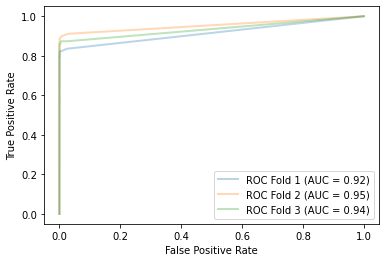

In [10]:
rfc = RandomForestClassifier(criterion='entropy', max_features='sqrt', random_state=23)
r = 0
fig, ax = plt.subplots()
for j in range(1,k+1):
    
    rfc.fit(d_train_df_X[j],d_train_s_y[j])
    rexp = rfc.predict(d_test_df_X[j])
    
    if i == 3:
        y_hat_rf = rexp
        
    rtrue_idx = d_test_s_y[j] == 1
    rfalse_idx = d_test_s_y[j] == 0
    rp_true_idx = rexp == 1
    
    rP = rtrue_idx.sum()
    rN = rfalse_idx.sum()
    rTP_p_FP = rp_true_idx.sum()
    
    rTP = ( rexp[rtrue_idx] == d_test_s_y[j][rtrue_idx] ).sum()
    rFP = rTP_p_FP - rTP
    rTN = rN - rFP
    
    np.put(acc_rf,[r],(rTP+rTN)/len(rexp))
    np.put(fpr_rf,[r],rFP/rN)
    np.put(ppv_rf,[r],rTP/rTP_p_FP)
    np.put(tpr_rf,[r],rTP/rP)
    
    r += 1
    plot_roc_curve(rfc,d_test_df_X[j], d_test_s_y[j], name = 'ROC Fold {}'.format(j),alpha = 0.3, lw=2, ax=ax)

plt.show()
    
    
    
        

In [11]:
print('The min, mean, and max TPR are: {:.2f}, {:.2f}, and {:.2f}'.format(tpr_rf.min(), tpr_rf.mean(), tpr_rf.max()))
print('The min, mean, and max PPV are: {:.2f}, {:.2f}, and {:.2f}'.format(ppv_rf.min(), ppv_rf.mean(), ppv_rf.max()))
print('The min, mean, and max ACC are: {:.2f}, {:.2f}, and {:.2f}'.format(acc_rf.min(), acc_rf.mean(), acc_rf.max()))

The min, mean, and max TPR are: 0.75, 0.78, and 0.80
The min, mean, and max PPV are: 0.92, 0.93, and 0.95
The min, mean, and max ACC are: 1.00, 1.00, and 1.00


# Calculate the Cost of Fraud 

In the above problems, I saved the predictions of the 3rd fold into the variables `y_hat_ab` and `y_hat_rf` for the AdaBoost and RandomForest models respectively. 

Now, imagine that the bank wants me to tell them how much money they are going to save if they deploy either of these fraud algorithms to the real-time payment processing system. Let's assume that there is not a currently deployed fraud detection algorithm.  

For every fraudulent transaction that is not predicted as fraudulent the bank looses twice that much money.  So, a fradulent charge for €10 is undectected, it costs the bank €20.  Also, if a charge is predicted as fradulent, but wasn't, it costs the bank a flat fee of €3 in customer service support to communicate with the customer, and mark the possible fraud as a normal transaction. 

By using the 3rd fold test sample, I will calculate how much moneythe bank will save with each algorithm, and make a recommendation of which algorithm to deploy to production.

In [12]:
df_amount = d_test_df_X[3]

total_ab = 0
total_rf = 0
s_y_list = d_test_s_y[3].tolist()
test = d_test_s_y[3]

none = 2*df_amount.loc[test[test== 1].index]['Amount'].sum()
                       
for j in range(len(test)):
    
    if y_hat_ab[j] == 0 and test.iloc[j] == 1: 
        total_ab += (2*df_amount.iloc[j]['Amount'])
        
    if y_hat_rf[j] == 0 and test.iloc[j] == 1:
        total_rf += (2*df_amount.iloc[j]['Amount'])
        
    if y_hat_ab[j] == 1 and test.iloc[j] == 0:
        total_ab += 3
        
    if y_hat_rf[j] == 1 and test.iloc[j] == 0:
        total_rf += 3
            


print('Not having an algorithm in place costs the bank: €{:.2f}.'.format(none))
print('Using the Random Forest algorithm saves the bank: €{:.2f}.'.format(none-total_rf))
print('Using the AdaBoost algorithm saves the bank: €{:.2f}.'.format(none-total_ab))

Not having an algorithm in place costs the bank: €22484.74.
Using the Random Forest algorithm saves the bank: €18121.36.
Using the AdaBoost algorithm saves the bank: €13946.42.


The bank will save more money if I deploy the Random Forest algorithm!